In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install imdlib
!pip install pymannkendall

# Downloading data

In [ ]:
# Downloading IMD data
path_data = "/content/drive/MyDrive/P2P_session"

In [ ]:
import imdlib as imd
import numpy as np
import matplotlib.pyplot as plt
import pymannkendall as mk

In [13]:
start_yr = 1951
end_yr = 2020
variable = 'tmax' # other options are ('tmin'/ 'tmax')
file_dir = (path_data) #Path to save the files
# imd.get_data(variable, start_yr, end_yr, fn_format='yearwise', file_dir=file_dir)

# Plotting

In [14]:
data = imd.open_data(variable, start_yr, end_yr,'yearwise', file_dir)
ds = data.get_xarray()

In [ ]:
ds.tmax

In [16]:
lon = ds.tmax.lon
lat = ds['tmax'].lat
ds = ds.where(ds.tmax <90) #Remove NaN values

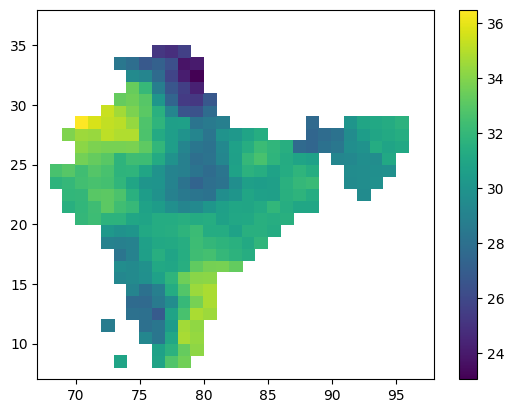

In [17]:
plt.figure()
plt.pcolor(lon, lat, ds.tmax[255, :, :],
          #  vmax= 20,
          #  vmin = 0,
          #  cmap = "Blues"
           );
plt.colorbar()


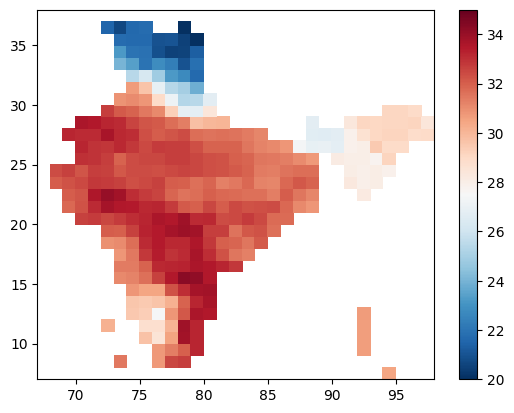

In [18]:
plt.figure()
plt.pcolor(lon, lat, ds.tmax.mean(dim="time"),
           vmax= 35,
           vmin = 20,
           cmap = "RdBu_r");
plt.colorbar()


# Slicing

In [19]:
ds.sel(time="2013-05")

<xarray.Dataset> Size: 239kB
Dimensions:  (time: 31, lat: 31, lon: 31)
Coordinates:
  * lat      (lat) float64 248B 7.5 8.5 9.5 10.5 11.5 ... 34.5 35.5 36.5 37.5
  * lon      (lon) float64 248B 67.5 68.5 69.5 70.5 71.5 ... 94.5 95.5 96.5 97.5
  * time     (time) datetime64[ns] 248B 2013-05-01 2013-05-02 ... 2013-05-31
Data variables:
    tmax     (time, lat, lon) float64 238kB nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.7
    title:        IMD gridded data
    source:       https://imdpune.gov.in/
    history:      2025-02-05 09:52:02.128384 Python
    references:   
    comment:      
    crs:          epsg:4326

In [20]:
ds.sel(time=slice("2013-05", "2013-07"))


<xarray.Dataset> Size: 709kB
Dimensions:  (time: 92, lat: 31, lon: 31)
Coordinates:
  * lat      (lat) float64 248B 7.5 8.5 9.5 10.5 11.5 ... 34.5 35.5 36.5 37.5
  * lon      (lon) float64 248B 67.5 68.5 69.5 70.5 71.5 ... 94.5 95.5 96.5 97.5
  * time     (time) datetime64[ns] 736B 2013-05-01 2013-05-02 ... 2013-07-31
Data variables:
    tmax     (time, lat, lon) float64 707kB nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:  CF-1.7
    title:        IMD gridded data
    source:       https://imdpune.gov.in/
    history:      2025-02-05 09:52:02.128384 Python
    references:   
    comment:      
    crs:          epsg:4326

In [21]:
ds_delhi_annual = ds.sel(lon=77.1025,lat = 28.7, method="nearest").groupby("time.year").mean()
jjas_prec  = ds_delhi_annual.tmax.data
# ds_delhi = ds.sel(lon=77.1025,lat = 28.7, method="nearest")
# ds_jjas =ds_delhi.where(ds_delhi.time.dt.month.isin([4,5,6,7]), drop=True).groupby("time.year").sum()
# ds_selected
# jjas_prec  = ds_jjas.rain.data

# Trend analysis for a point location

-0.798% in 70 years (p=0.052)


Text(0.5, 1.0, 'Annual mean Tmax')

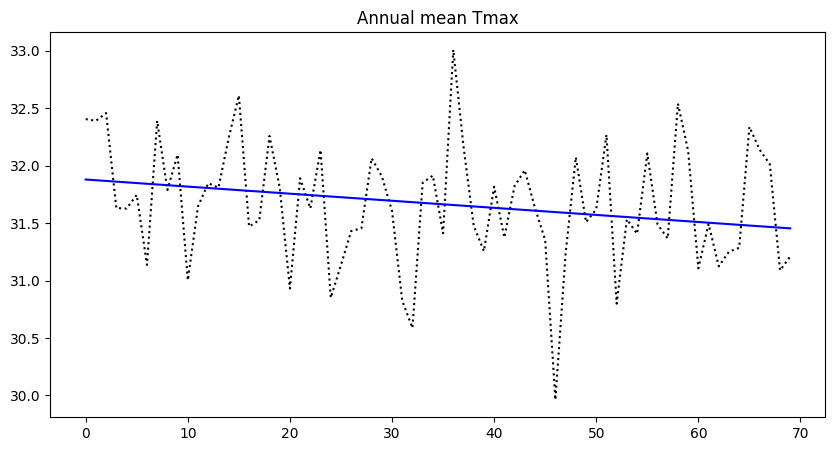

In [22]:
def plot_trend(data_trend,c):
    N=data_trend.shape[0]
    result = mk.original_test(data_trend)
    print(str(np.round(result.slope/np.mean(data_trend)*41*100*1000)/1000)+ '% in '+str(N)+' years (p=' + str(np.round(result.p*1000)/1000)+')')
#     plt.plot(data_trend)
    plt.plot(np.mean(data_trend)+np.arange(N) * result.slope - N*0.5* result.slope, c )


plt.figure(figsize=(10,5))
plt.plot(jjas_prec,':k')
plot_trend(jjas_prec,'b')
plt.title('Annual mean Tmax')


# Gridwise trend analysis

In [24]:
da = ds.where(ds.tmax != -999.) #Remove NaN values
ds_jjas =da.where(da.time.dt.month.isin([4,5,6,7]), drop=True).groupby("time.year").mean().tmax.data

mask = ds.tmax.mean(dim="time").data >0
mask = np.where(mask, 1,np.nan)


In [48]:
import geopandas as gpd
shapefile_path = "/content/drive/MyDrive/P2P_session/india_shapefile/ind.shp"  # Replace with your actual shapefile path
shape_data = gpd.read_file(shapefile_path)

In [31]:
_,N1,N2 = ds_jjas.shape
slope_monthly=np.zeros((N1,N2))*np.nan
pval_monthly=np.zeros((N1,N2))*np.nan

for n1 in range(N1):
    for n2 in range(N2):
        if np.sum(np.isnan(ds_jjas[:,n1,n2])) < 1:
            data_trend=ds_jjas[:,n1,n2]

            N=data_trend.shape[0]
            result = mk.original_test(data_trend)
            slope_monthly[n1,n2]=np.round(result.slope*N*1000)/1000
            pval_monthly[n1,n2]=np.round(result.p*1000)/1000



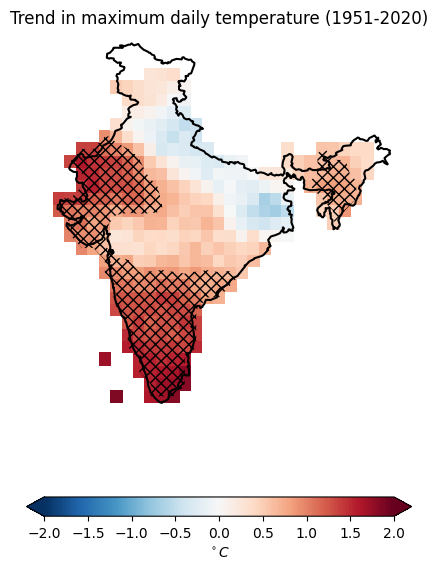

In [47]:
 plt.figure(figsize=(8, 6))
 im=plt.gca().pcolor(lon,lat,slope_monthly*mask,
                    cmap= 'RdBu_r',
                    vmax = 2,
                    vmin = -2)

plt.colorbar(im,extend  ='both',label ='$^\circ C$',orientation ='horizontal',shrink = 0.5)
plt.contourf(lon,lat,pval_monthly,
            cmap=None,extend='both',
             levels=[0.01,1],hatches=['xxx',None],
            colors='none')
shape_data.boundary.plot(ax=plt.gca(), edgecolor='black')

plt.axis('off')
plt.title('Trend in maximum daily temperature (1951-2020)')
plt.tight_layout()


# Reading NC files

In [50]:
import xarray as xr

In [51]:
# pip install netcdf4

In [52]:
data_from_nc_1 = xr.open_dataset("/content/drive/MyDrive/P2P_session/IMD_rainfall_nc/rainfall_2000.nc")
data_from_nc_2 = xr.open_dataset("/content/drive/MyDrive/P2P_session/IMD_rainfall_nc/rainfall_2001.nc")
data_from_nc_1,data_from_nc_2

(<xarray.Dataset> Size: 3MB
 Dimensions:    (LONGITUDE: 35, LATITUDE: 33, TIME: 366)
 Coordinates:
   * LONGITUDE  (LONGITUDE) float64 280B 66.5 67.5 68.5 69.5 ... 98.5 99.5 100.5
   * LATITUDE   (LATITUDE) float64 264B 6.5 7.5 8.5 9.5 ... 35.5 36.5 37.5 38.5
   * TIME       (TIME) datetime64[ns] 3kB 2000-01-01 2000-01-02 ... 2000-12-31
 Data variables:
     RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 3MB ...
 Attributes:
     history:      FERRET V7.5 (optimized) 28-Mar-22
     Conventions:  CF-1.6,
 <xarray.Dataset> Size: 3MB
 Dimensions:    (LONGITUDE: 35, LATITUDE: 33, TIME: 365)
 Coordinates:
   * LONGITUDE  (LONGITUDE) float64 280B 66.5 67.5 68.5 69.5 ... 98.5 99.5 100.5
   * LATITUDE   (LATITUDE) float64 264B 6.5 7.5 8.5 9.5 ... 35.5 36.5 37.5 38.5
   * TIME       (TIME) datetime64[ns] 3kB 2001-01-01 2001-01-02 ... 2001-12-31
 Data variables:
     RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 3MB ...
 Attributes:
     history:      FERRET V7.5 (optimized) 28-Mar-22
     Conv

In [53]:
combined_ = xr.concat([data_from_nc_1, data_from_nc_2], dim="TIME")

In [ ]:
combined_

<xarray.Dataset> Size: 7MB
Dimensions:    (TIME: 731, LATITUDE: 33, LONGITUDE: 35)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 280B 66.5 67.5 68.5 69.5 ... 98.5 99.5 100.5
  * LATITUDE   (LATITUDE) float64 264B 6.5 7.5 8.5 9.5 ... 35.5 36.5 37.5 38.5
  * TIME       (TIME) datetime64[ns] 6kB 2000-01-01 2000-01-02 ... 2001-12-31
Data variables:
    RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 7MB nan nan nan ... nan nan
Attributes:
    history:      FERRET V7.5 (optimized) 28-Mar-22
    Conventions:  CF-1.6